**Обучение на частично размеченном датасете.  
Метод Self-Training.**


Евгений Борисов <esborisov@sevsu.ru>

---

$X,Y$ - учебный набор, частично размеченный;   
$X^ℓ = \lbrace x_1,\ldots, x_ℓ \rbrace$, $\lbrace y_1, \ldots, y_ℓ \rbrace$ - размеченная часть выборки (labeled data);    
$X^k = \lbrace x_{ℓ+1},\ldots, x_{ℓ+k} \rbrace$ - неразмеченная часть выборки (unlabeled data);	

$b_y(x)$ - оценка принадлежности объекта $x$ к классу $y$

классификатор - выбираем для объекта $x$ класс $y$ с наилучшей оценкой $b$ ;

$$a(x) = \arg \max_{у\in Y} b_y(x)$$

In [1]:
import numpy as np
from numpy import random as rng

## генерируем данные 

In [7]:
from sklearn.datasets import make_moons

# генерируем датасет
X,target = make_moons(n_samples=500,noise=.1)
X.shape

(500, 2)

In [15]:
# случайным образом делим датасет на размеченный и неразмеченный
while True: 
    random_unlabeled_points = rng.rand(len(target))<.98
    target_partial = target.copy()
    target_partial[random_unlabeled_points] = -1

    if ( # проверяем минимальное количество размеченных объектов в классах 
        ((target[~random_unlabeled_points]>0).sum()>4)
        & ((target[~random_unlabeled_points]<1).sum()>4)
    ): break

len(target),random_unlabeled_points.sum()

(500, 488)

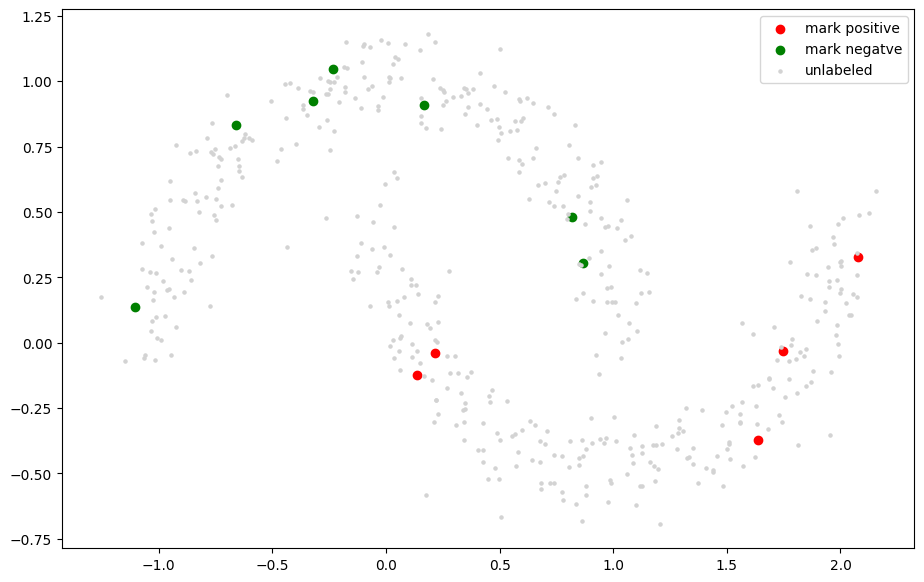

In [16]:
from matplotlib import pyplot as plt

plt.figure(figsize=(11,7))
plt.scatter(X[target_partial==1][:,0],X[target_partial==1][:,1],c='r',label='mark positive')
plt.scatter(X[target_partial==0][:,0],X[target_partial==0][:,1],c='g',label='mark negatve')
plt.scatter(X[target_partial==-1][:,0],X[target_partial==-1][:,1],c='lightgrey',s=5,label='unlabeled')
plt.legend()

## "простой" классификатор

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       250
           1       0.86      0.70      0.78       250

    accuracy                           0.80       500
   macro avg       0.81      0.80      0.79       500
weighted avg       0.81      0.80      0.79       500



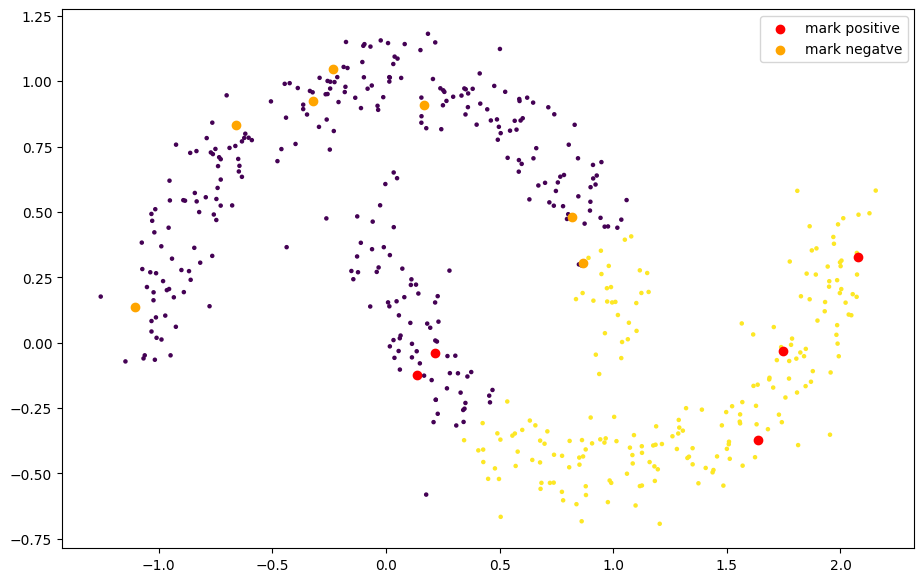

In [17]:
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier().fit(X[~random_unlabeled_points],target[~random_unlabeled_points])

o = model.predict(X)
print(classification_report(target,o))

plt.figure(figsize=(11,7))
plt.scatter(X[target_partial==-1][:,0],X[target_partial==-1][:,1],c=o[target_partial==-1],s=5)
plt.scatter(X[target_partial==1][:,0],X[target_partial==1][:,1],c='r',label='mark positive')
plt.scatter(X[target_partial==0][:,0],X[target_partial==0][:,1],c='orange',label='mark negatve')
plt.legend()

## Self-Training классификатор

David Yarowsky    
Unsupervised word sense disambiguation rivaling supervised methods.    
Proceedings of the 33rd annual meeting on Association for Computational Linguistics (ACL ‘95).     
Association for Computational Linguistics, Stroudsburg, PA, USA, 189-196.   
https://dl.acm.org/doi/pdf/10.3115/981658.981684

---

оценка "степень доверия" классификации,  
насколько оценка класса-победителя лучше оценок остальных классов


$$ y = a(b(x)) $$
$$ M(x|a) = \max_{y\in Y} b_y(x) - \max_{q\in Y\setminus y}  b_q(x) $$

Алгоритм self-training — обёртка (wrapper) над произвольным методом обучения классификатора:
    

    
Z := Xℓ ;

пока |Z| < ℓ+k:  
- $a(b((Z))$ ; обучить классификатор $a$ на размеченных данных $Z$
- $X_∆ := \lbrace x\ |\ x \in X^k\setminus Z\ ; M(x|a) > M_0 \rbrace$ ; оценить неразмеченные и выбрать "надёжные"
- $y_∆ := \lbrace  a(x) | x \in X_∆ \rbrace $  ; доразметить "надёжные"
- $Z := Z \cup \lbrace X_∆, y_∆ \rbrace$ ; добавить новые к размеченным  


              precision    recall  f1-score   support

           0       0.89      0.99      0.93       250
           1       0.99      0.87      0.93       250

    accuracy                           0.93       500
   macro avg       0.94      0.93      0.93       500
weighted avg       0.94      0.93      0.93       500



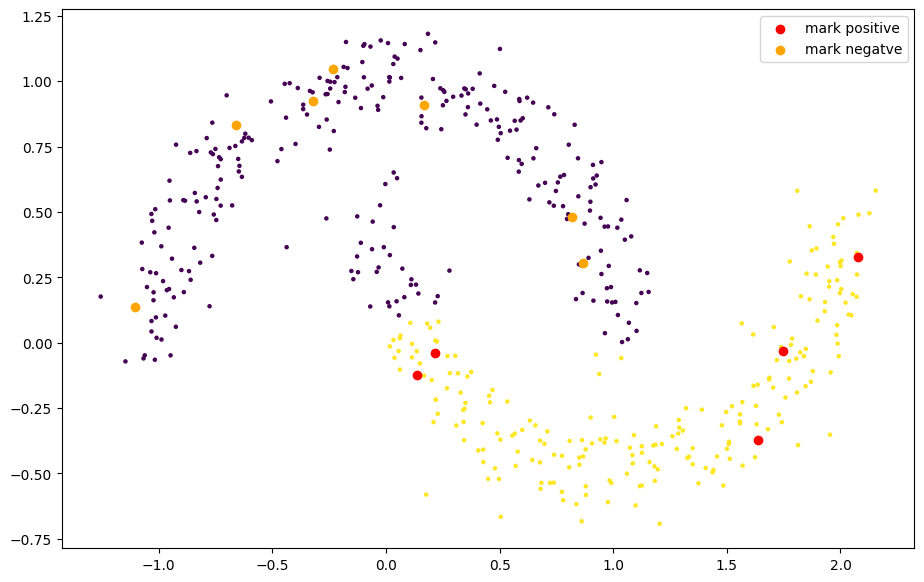

In [19]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

from sklearn.semi_supervised import SelfTrainingClassifier

from sklearn.neighbors import KNeighborsClassifier
model = SelfTrainingClassifier( KNeighborsClassifier(),threshold=.75 ).fit(X,target_partial)

o = model.predict(X)
print(classification_report(target,o))

plt.figure(figsize=(11,7))
plt.scatter(X[target_partial==-1][:,0],X[target_partial==-1][:,1],c=o[target_partial==-1],s=5)
plt.scatter(X[target_partial==1][:,0],X[target_partial==1][:,1],c='r',label='mark positive')
plt.scatter(X[target_partial==0][:,0],X[target_partial==0][:,1],c='orange',label='mark negatve')
plt.legend()

## LabelPropagation

Xiaojin Zhu and Zoubin Ghahramani.   
Learning from labeled and unlabeled data with label propagation.   
Technical Report CMU-CALD-02-107, Carnegie Mellon University, 2002   
http://pages.cs.wisc.edu/~jerryzhu/pub/CMU-CALD-02-107.pdf

Label Propagation Algorithm and its Application.  
Dezhou Chen  
Jul 15, 2021   
https://medium.com/@dezhouc2/label-propagation-algorithm-and-its-application-162d03f10d3a

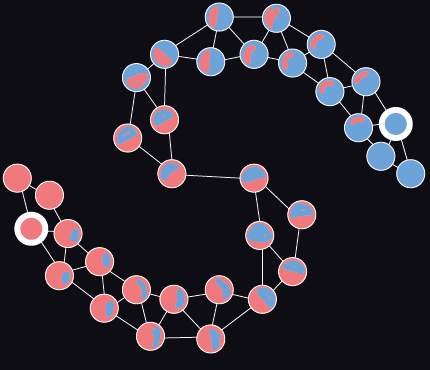

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       250
           1       1.00      0.99      0.99       250

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



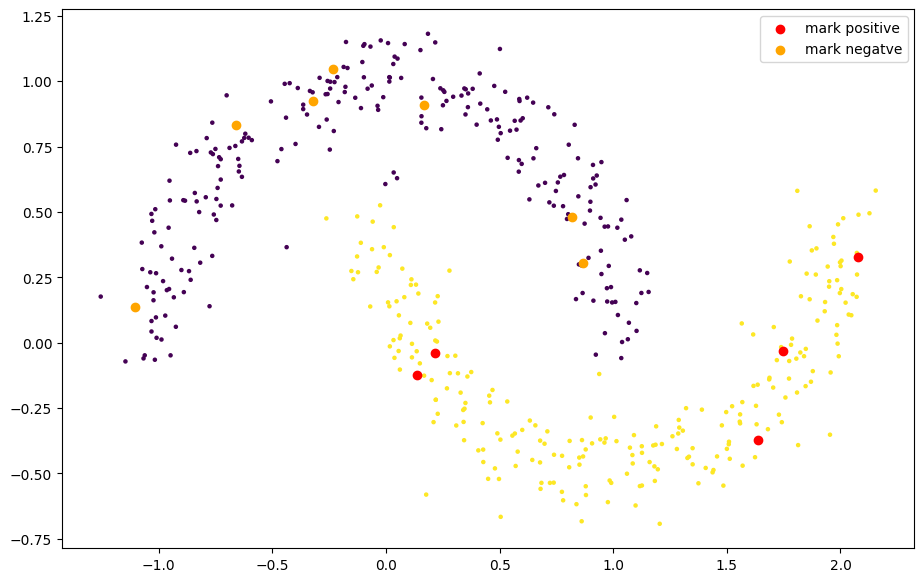

In [20]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

from sklearn.semi_supervised import LabelPropagation

model = LabelPropagation().fit(X,target_partial)

o = model.predict(X)
print(classification_report(target,o))

plt.figure(figsize=(11,7))
plt.scatter(X[target_partial==-1][:,0],X[target_partial==-1][:,1],c=o[target_partial==-1],s=5)
plt.scatter(X[target_partial==1][:,0],X[target_partial==1][:,1],c='r',label='mark positive')
plt.scatter(X[target_partial==0][:,0],X[target_partial==0][:,1],c='orange',label='mark negatve') 
plt.legend()